<a href="https://colab.research.google.com/github/BSteiner1/Adversarial-Examples/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import io
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = 'drive/MyDrive/MA498/TinyImageNet.parquet'
tiny_imagenet_df = pd.read_parquet(dataset_path)

In [4]:
# Function to decode image bytes
def decode_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return image

# Decode images
tiny_imagenet_df['decoded_image'] = tiny_imagenet_df['image'].apply(lambda x: decode_image(x['bytes']))

Label: 0


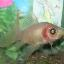

Label: 0


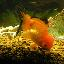

Label: 0


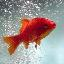

Label: 0


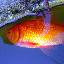

Label: 0


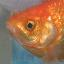

In [5]:
# Display the first few images
for i in range(5):
    image = tiny_imagenet_df.loc[i, 'decoded_image']
    label = tiny_imagenet_df.loc[i, 'label']
    print(f"Label: {label}")
    display(image)

In [6]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(tiny_imagenet_df, test_size=0.2)

# Verify the sizes of the train and test sets
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 80000
Test set size: 20000


In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor()           # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

In [8]:
# Custom Dataset class
class TinyImageNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['decoded_image']
        label = self.dataframe.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Create Dataset objects
train_dataset = TinyImageNetDataset(train_df, transform=transform)
test_dataset = TinyImageNetDataset(test_df, transform=transform)

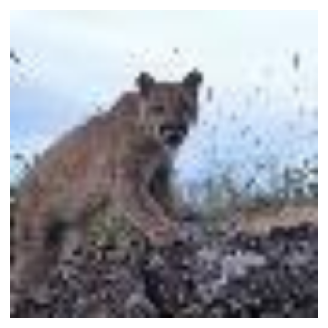

In [99]:
image = train_dataset[15][0]
# Convert the tensor to a numpy array
np_image = image.permute(1, 2, 0).cpu().numpy()  # Move channels to the last dimension and convert to numpy

# Display the numpy array as an image
plt.figure(figsize=(4,4))
plt.imshow(np_image)
plt.axis('off')
plt.show()

In [11]:
# Create a new list to store indices of items to remove
indices_to_remove = []

# Iterate over the dataset and identify items with the specified shape
for idx in range(10000):
    image, _ = train_dataset[idx]
    if image.shape != torch.Size([3, 224, 224]):
        indices_to_remove.append(idx)

# Create a new dataset excluding items with the specified indices
train_dataset = torch.utils.data.Subset(train_dataset, [idx for idx in range(len(train_dataset)) if idx not in indices_to_remove])

In [12]:
train_dataset = torch.utils.data.Subset(train_dataset, [i for i in range(20)])

In [13]:
len(train_dataset)

20

In [14]:
for i in range(len(train_dataset)):
  if train_dataset[i][0].shape != torch.Size([3, 224, 224]):
    print(i)
    print(train_dataset[i][0].shape)

In [15]:
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [55]:
vgg16 = models.vgg16(pretrained=True)

vgg16.eval()
# Assuming you have loaded your test data into the 'image' tensor
with torch.no_grad():
    output = vgg16(image)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
output

tensor([[ 1.6359e+00,  9.1151e-01, -9.2262e-01,  1.4679e+00,  1.3353e+00,
          8.0916e+00,  2.4955e+00, -1.0537e+00, -3.6273e-01, -3.3855e-01,
          8.9070e-01, -1.6590e+00, -2.0337e+00, -7.7437e-02, -3.8916e-01,
         -7.8038e-01, -1.5196e+00, -1.6332e+00, -1.4594e+00, -1.3279e+00,
         -6.1264e-01, -2.1709e+00, -2.8770e+00, -2.1483e+00, -2.9635e+00,
          3.1542e+00,  5.2886e+00,  3.0674e+00,  2.7287e+00,  4.1287e+00,
          9.6261e-01,  6.9849e-01,  4.0806e+00,  4.0674e+00,  4.4696e+00,
          2.7368e+00,  3.3914e+00,  1.1546e+00,  6.1452e+00,  7.9131e-01,
          6.7680e-01,  5.0311e+00,  2.5550e+00,  2.8834e+00,  3.3331e+00,
          4.3600e+00,  5.3337e-01,  2.8059e+00,  6.1374e-01,  1.6341e+00,
          6.2049e-01,  6.5314e-01,  4.3982e+00,  2.9790e+00,  3.8815e+00,
          4.7060e-01,  2.6547e+00,  1.5921e+00,  3.8995e+00,  2.6256e+00,
          4.9209e+00,  2.1757e+00,  5.1720e+00,  4.1830e+00,  2.8752e+00,
          7.0860e+00,  6.6189e+00,  2.

In [63]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16()

# Optionally, freeze the weights of the convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

for param in vgg16.classifier.parameters():
    param.requires_grad = False

#vgg16.classifier[6] = nn.Linear(4096, 200)

# Add a new fully connected layer to further reduce the number of output classes from 1000 to 200
vgg16.classifier.add_module("7", nn.ReLU(inplace=True))
vgg16.classifier.add_module("8", nn.Dropout(p=0.5))
vgg16.classifier.add_module("9", nn.Linear(1000, 200))

# Extract the feature extractor and classifier
# features = vgg16.features
# classifier = vgg16.classifier
# avgpool = vgg16.avgpool

# Combine the layers using nn.Sequential
vgg16 = nn.Sequential(
    *list(vgg16.features.children()),  # Exclude the last layer (avgpool)
    *list(vgg16.avgpool.children()),
    nn.Flatten(),  # Add a Flatten layer
    *list(vgg16.classifier.children())
)

# Display the modified VGG16 architecture
print(vgg16)

    # nn.Linear(49, 4096),
    # nn.ReLU(inplace=True),
    # nn.Dropout(p=0.5, inplace=False),

    #nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
    #nn.ReLU(inplace=True),
    #nn.MaxPool2d(kernel_size=2, stride=2),

# Set the model to training mode
#vgg16.train()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [58]:
from tqdm import tqdm

In [59]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001)

# Training loop
num_epochs = 1  # Example number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    # Wrap train_loader with tqdm to add a progress bar
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1: 100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

Epoch 1, Loss: 5.302644681930542


In [103]:
input = image.unsqueeze(0)

In [104]:
vgg16.eval()

# Assuming you have new data stored in a tensor called new_data
with torch.no_grad():
    predictions = vgg16(input)

In [105]:
# Define a hook to capture feature maps
feature_maps = []
def hook_fn(module, input, output):
    feature_maps.append(output)

# Choose the convolutional layer from which you want to extract feature maps
# For example, let's choose the first convolutional layer (Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))
conv_layer_index = 12

# Register the hook to the chosen convolutional layer
#vgg16[conv_layer_index].register_forward_hook(hook_fn)

In [106]:
# Choose the layer from which you want to extract feature maps
target_layer = vgg16[12]  # Example: extracting from the 12th convolutional layer

# Register the hook to the target layer
handle = target_layer.register_forward_hook(hook_fn)

# Initialize a list to store the extracted feature maps
feature_maps = []

# Assuming 'image' is your input tensor


# Perform inference
with torch.no_grad():
    output = vgg16(input)

# Remove the hook
handle.remove()

# Visualize the extracted feature maps
# for i, feature_map in enumerate(feature_maps):
#     # Plot each feature map in a grid
#     for j in range(feature_map.size(1)):  # Iterate over channels
#         plt.subplot(feature_map.size(1), 1, j + 1)
#         plt.imshow(feature_map[0, j].cpu().numpy(), cmap='gray')  # Assuming grayscale feature maps
#         plt.axis('off')
#         plt.title(f'Channel {j}')
#     plt.show()

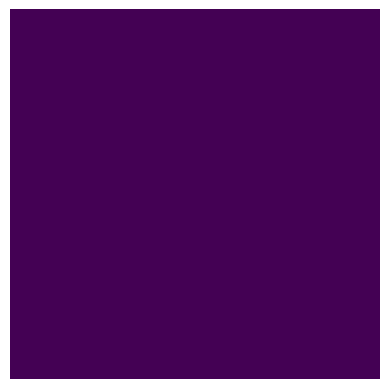

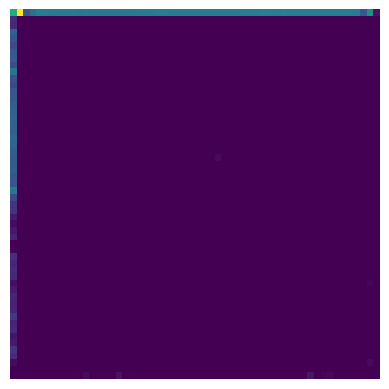

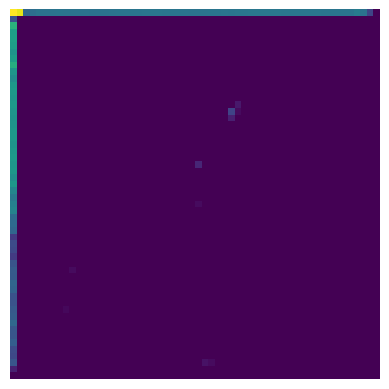

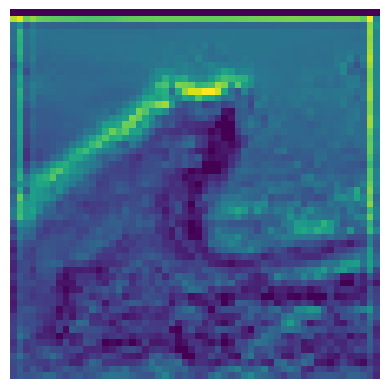

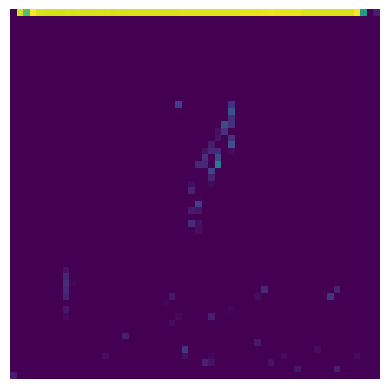

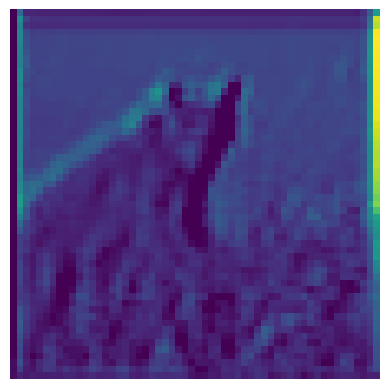

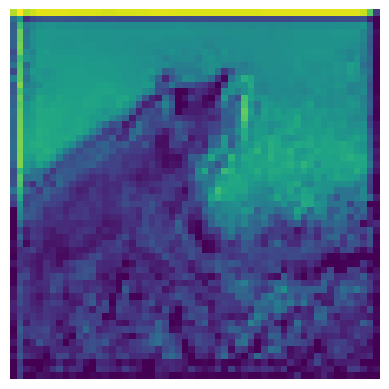

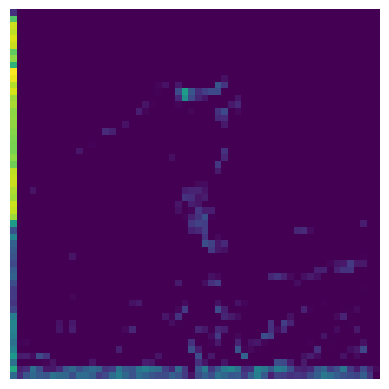

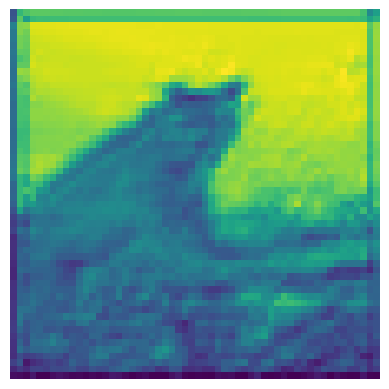

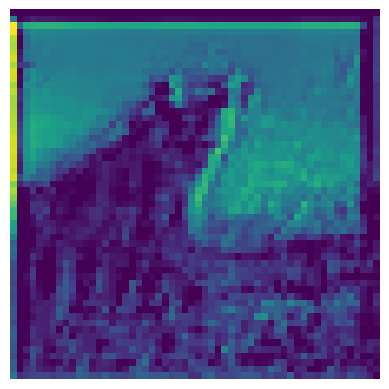

In [108]:
for i in range(10):
  img = feature_maps[0][0][i]
  img = img.squeeze().numpy()
  plt.imshow(img)  # Assuming your input image is grayscale
  plt.axis('off')
  plt.show()